<a href="https://colab.research.google.com/github/gcalanch/DMA-Caras/blob/main/clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


Carga librerias

In [ ]:
import polars as pl
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.manifold import Isomap
from PIL import Image

# Clase Multiperceptron

In [ ]:
# definicion de las funciones de activacion
# y sus derivadas agregando las versiones VECTORIZADAS
def func_eval(fname, x):
    if fname == "purelin":
        return x
    elif fname == "logsig":
        return 1.0 / (1.0 + np.exp(-x))
    elif fname == "tansig":
        return 2.0 / (1.0 + np.exp(-2.0 * x)) - 1.0
    else:
        raise ValueError(f"Función de activación no soportada: {fname}")

# version vectorizada de func_eval
func_eval_vec = np.vectorize(func_eval)

def deriv_eval(fname, y):
    if fname == "purelin":
        return 1.0
    elif fname == "logsig":
        return y * (1.0 - y)
    elif fname == "tansig":
        return 1.0 - y * y

# version vectorizada de deriv_eval
deriv_eval_vec = np.vectorize(deriv_eval)

# Definicion de la clase de multiperceptron (red neuronal con múltiples capas ocultas)

class multiperceptron(object):
    """Multiperceptron class"""

    def _red_init(self, semilla) -> None:

        niveles = self.red['arq']['layers_qty']
        np.random.seed(semilla)

        for i in range(niveles):
           nivel = dict()
           nivel['id'] = i
           nivel['last'] = (i==(niveles-1))
           nivel['size'] = self.red["arq"]["layers_size"][i]
           nivel['func'] = self.red["arq"]["layers_func"][i]

           # Se determina cuántas entradas recibe la capa actual
           if( i==0 ):
              entrada_size = self.red['arq']['input_size']
           else:
              entrada_size =  self.red['arq']['layers_size'][i-1]

           salida_size =  nivel['size']

           # los pesos, inicializados random
           nivel['W'] = np.random.uniform(-0.5, 0.5, [salida_size, entrada_size])
           nivel['w0'] = np.random.uniform(-0.5, 0.5, [salida_size, 1])

           # los momentos, inicializados en CERO
           nivel['W_m'] = np.zeros([salida_size, entrada_size])
           nivel['w0_m'] = np.zeros([salida_size, 1])

           self.red['layer'].append(nivel)

    # constructor generico
    def __init__(self) -> None:
        self.data = dict()
        self.red = dict()
        self.carpeta = ""

    # inicializacion full
    def inicializar(self, df, campos, clase, hidden_layers_sizes, layers_func,
                 semilla, carpeta) -> None:

        # Procesamiento de los datos de entrada (features)
        self.data['X'] = np.array(df.select(campos))
        # Normalización (escalado) de los datos para que los atributos tengan media 0 y desviación estándar 1
        X_mean = self.data['X'].mean(axis=0)
        X_sd = self.data['X'].std(axis=0)
        self.data['X'] = (self.data['X'] - X_mean)/X_sd

        #  Procesamiento de etiquetas Ylabel en  numpy
        label =df.select(clase)
        self.data['Ylabel'] = np.array(label).reshape(len(label))

        # one-hot-encoding de Y . Realiza la codificacion "one hot" de las etiquetas (Convierte cada categoría única en una columna binaria separada y representa la presencia con 1 y la ausencia con 0.)
        col_originales = df.columns
        self.data['Y'] = np.array( df.to_dummies(clase).drop(col_originales, strict=False) )
        col_dummies = sorted( list( set(df.to_dummies(clase).columns) -  set(col_originales)))
        # Need to import reduce from functools
        from functools import reduce
        clases_originales = reduce(lambda acc, x: acc + [x[(len(clase)+1):]], col_dummies, [])


        # Construcción de la arquitectura de la red
        tamanos = hidden_layers_sizes
        tamanos.append(self.data['Y'].shape[1])

        arquitectura = {
             'input_size' : self.data['X'].shape[1],
             'input_mean' : X_mean,
             'input_sd' :  X_sd,
             'output_values' : clases_originales,
             'layers_qty' : len(hidden_layers_sizes),
             'layers_size' : tamanos ,
             'layers_func' : layers_func,
        }

        self.red['arq'] = arquitectura

        # inicializo  work . Inicialización de información de entrenamiento
        self.red['work'] = dict()
        self.red['work']['epoch'] = 0
        self.red['work']['MSE'] = float('inf')
        self.red['work']['train_error_rate'] = float('inf')

        # Preparación de las capas y pesos
        self.red['layer'] = list()
        self._red_init(semilla)

        # grabo el entorno. Guardar el entorno en disco
        self.carpeta = carpeta
        os.makedirs(self.carpeta, exist_ok=True)
        with open(self.carpeta+"/data.pkl", 'wb') as f:
            pickle.dump(self.data, f)

        with open(self.carpeta+"/red.pkl", 'wb') as f:
            pickle.dump(self.red, f)


    # predigo a partir de modelo recien entrenado
    def  predecir(self, df_new, campos, clase) -> None:


        niveles = self.red['arq']['layers_qty']

        # etapa forward
        # recorro hacia adelante, nivel a nivel
        X_new =  np.array( df_new.select(campos))


        # estandarizo manualmente con las medias y desvios que almacene durante el entrenamiento
        X_new = (X_new - self.red['arq']['input_mean'])/self.red['arq']['input_sd']


        # la entrada a la red,  el X que es TODO  x_new
        entrada = X_new.T

        for i in range(niveles):
          estimulos = self.red['layer'][i]['W'] @ entrada + self.red['layer'][i]['w0']
          salida =  func_eval_vec(self.red['layer'][i]['func'], estimulos)
          entrada = salida  # para la proxima vuelta

        # me quedo con la neurona de la ultima capa que se activio con mayor intensidad
        pred_idx = np.argmax( salida.T, axis=1)
        pred_raw = np.max( salida.T, axis=1)
        # Inicializamos out y error_rate a None
        out=None
        new_error_rate = None

        if clase: # Verificamos si la variable clase tiene un valor (no es cadena vacía o None)
            out = np.array(self.red['arq']['output_values'])

            true_labels = np.array(df_new.select(clase)).flatten() # Aseguramos que sea un array plano

            predicted_labels = out[pred_idx] # Estos serán strings (nombres de clase)
            new_error_rate = np.mean(true_labels != predicted_labels)

        # Modify the return statement to handle the case where 'out' is None
        # If 'out' is None, we return the raw indices instead of trying to use 'out'
        # If 'out' is not None, we return the predicted class names based on the indices
        if out is not None:
            return (out[pred_idx], pred_raw, new_error_rate)
        else:
            # When 'clase' is not provided, we cannot return class names, so we return
            # the indices of the activated neurons instead of trying to access 'out'
            # We also return None for new_error_rate as true labels are not available
            return (pred_idx, pred_raw, new_error_rate)


    # cargo un modelo ya entrenado, grabado en carpeta
    def cargar_modelo(self, carpeta) -> None:
        self.carpeta = carpeta

        with open(self.carpeta+"/red.pkl", 'rb') as f:
          self.red = pickle.load(f)

        return (self.red['work']['epoch'],
                self.red['work']['MSE'],
                self.red['work']['train_error_rate'] )


# Directorios y campos de entrada

In [ ]:
modelo_path = "/content/drive/MyDrive/DMA/prod"
datos_path = "/content/drive/MyDrive/DMA/prod"
imagenes_path ="/content/drive/MyDrive/DMA/Datos_Produccion"
salida_path = "/content/drive/MyDrive/caras/prod/resultados.csv"
fotos = "/content/drive/MyDrive/DMA/Datos_Clasif"

campos = [f"PC{i}" for i in range(1, 51)]

# Ejecucion

Carga de datos

In [ ]:
imagenes = []
etiquetas = []

print("Cargando imágenes...")
for persona in os.listdir(imagenes_path):
    ruta_persona = os.path.join(imagenes_path, persona)
    if os.path.isdir(ruta_persona):
        for img in os.listdir(ruta_persona):
            if img.lower().endswith(('.png', '.jpg', '.jpeg')):
                ruta_imagen = os.path.join(ruta_persona, img)
                imagenes.append(ruta_imagen)
                etiquetas.append(persona)

print(f"Total de imágenes cargadas: {len(imagenes)}")
if imagenes:
    muestra = np.array(Image.open(imagenes[0]).convert('L'))
    print(f"Dimensión de cada imagen: {muestra.shape} (total features: {muestra.size})")

Cargando imágenes...
Total de imágenes cargadas: 0


In [ ]:
# Identificar archivos de imagenes sin etiquetas
def leer_imagenes(i_path):
    """
    Identifica archivos de imagen en una carpeta que no están en subcarpetas (consideradas "etiquetas").
    Args:
        i_path (str): La ruta a la carpeta principal donde buscar imágenes.
    Returns:
        list: Una lista de rutas a archivos de imagen que no se encuentran en ninguna subcarpeta.
    """
    imagenes = []
    if not os.path.isdir(i_path):
        print(f"La ruta '{i_path}' no es un directorio válido.")
        return imagenes

    for item in os.listdir(i_path):
        item_path = os.path.join(i_path, item)
        if os.path.isfile(item_path) and item.lower().endswith(('.png', '.jpg', '.jpeg')):
            imagenes.append(item_path)

    return imagenes

print(f"Buscando imágenes sin etiqueta en: {imagenes_path}")
imagenes = leer_imagenes(imagenes_path)

if imagenes:
    print(f"Se encontraron {len(imagenes)} imágenes sin etiqueta:")
else:
    print("No se encontraron imágenes sin etiqueta en el directorio especificado.")


Buscando imágenes sin etiqueta en: /content/drive/MyDrive/DMA/Datos_Produccion
Se encontraron 493 imágenes sin etiqueta:


In [ ]:
print("Vectorizando imágenes y aplicando reducción de dimensionalidad con Isomap...")
imagenes_vectorizadas = np.array([np.array(Image.open(img).convert('L')).flatten() for img in imagenes])

isomap = Isomap(n_neighbors=12, n_components=50)
imagenes_isomap = isomap.fit_transform(imagenes_vectorizadas)

print(f"Dimensión después de Isomap: {imagenes_isomap.shape}")

Vectorizando imágenes y aplicando reducción de dimensionalidad con Isomap...
Dimensión después de Isomap: (493, 50)


# SALTAR

In [ ]:
ruta_isomap = os.path.join(modelo_path, 'modelo_isomap.pkl')

with open(ruta_isomap, 'wb') as f:
  pickle.dump(isomap, f)

Carga Modelo ISOMAP

In [ ]:
# Verifica si el archivo existe antes de intentar cargarlo
if os.path.exists(ruta_isomap):
  print(f"Cargando modelo Isomap desde: {ruta_isomap}")
  with open(ruta_isomap, 'rb') as f:
    isomap = pickle.load(f)
    print("Modelo Isomap cargado exitosamente.")
else:
  print(f"Advertencia: No se encontró el archivo del modelo Isomap en {ruta_isomap}.")

Cargando modelo Isomap desde: /content/drive/MyDrive/DMA/prod/modelo_isomap.pkl
Modelo Isomap cargado exitosamente.


In [ ]:
print(f"Buscando imágenes sin etiqueta en: {fotos}")
imagenes_prod = leer_imagenes(fotos)

if imagenes_prod:
    print(f"Se encontraron {len(imagenes_prod)} imágenes sin etiqueta:")
else:
    print("No se encontraron imágenes sin etiqueta en el directorio especificado.")

Buscando imágenes sin etiqueta en: /content/drive/MyDrive/DMA/Datos_Clasif
Se encontraron 13 imágenes sin etiqueta:


In [ ]:
print("Vectorizando imágenes y aplicando reducción de dimensionalidad con Isomap...")
imagenes_vectorizadas = np.array([np.array(Image.open(img).convert('L')).flatten() for img in imagenes_prod])

Vectorizando imágenes y aplicando reducción de dimensionalidad con Isomap...


In [ ]:
# Usa el modelo isomap para transformar los nuevos datos.
imagenes_isomap = isomap.transform(imagenes_vectorizadas)

print(f"Dimensión después de Isomap: {imagenes_isomap.shape}")

Dimensión después de Isomap: (13, 50)


# RETOMAR

In [ ]:
data_dict = {f"PC{i+1}": imagenes_isomap[:, i] for i in range(imagenes_isomap.shape[1])}
# Usar la lista imagenes_prod que corresponde a las imágenes que fueron transformadas por Isomap
data_dict["ruta_imagen"] = imagenes_prod
df_isomap = pl.DataFrame(data_dict)


print("DataFrame creado a partir de Isomap:")
print(df_isomap.head())

DataFrame creado a partir de Isomap:
shape: (5, 51)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ PC1       ┆ PC2       ┆ PC3       ┆ PC4       ┆ … ┆ PC48      ┆ PC49      ┆ PC50      ┆ ruta_ima │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ gen      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ -4101.887 ┆ 630.01799 ┆ -1623.904 ┆ 3920.0416 ┆ … ┆ 52.188774 ┆ -233.2225 ┆ 446.34626 ┆ /content │
│ 797       ┆           ┆ 436       ┆ 82        ┆   ┆           ┆ 91        ┆ 3         ┆ /drive/M │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ yDrive/D │
│           ┆           ┆           ┆  

Carga modelo etrenado

In [ ]:
mp_prod = multiperceptron()
mp_prod.cargar_modelo(modelo_path)

(141, np.float64(0.0009935644838181643), np.float64(0.008113590263691683))

Prediccion

In [ ]:
# Predecir (pasamos una columna vacía como clase)

(y_hat, y_raw, new_error_rate)= mp_prod.predecir(df_isomap, campos, clase="")

Visualizacion de las Predicciones

In [ ]:
#visualizar las predicciones con el nombre de las etiquetas usadas para entrenamiento

with open(modelo_path + "/red.pkl", 'rb') as f:# Cargar el archivo red.pkl para obtener los nombres de las etiquetas
    red_info = pickle.load(f)

clases_originales = red_info['arq']['output_values']# Obtener los nombres de las etiquetas originales

# Crea un nuevo DataFrame Polars con los resultados
df_resultados = df_isomap.with_columns([
    pl.Series(name="etiqueta_predicha", values=[clases_originales[idx] for idx in y_hat]),
    pl.Series(name="intensidad_predicha", values=y_raw)
])

# Guarda el nuevo DataFrame en un archivo CSV
df_resultados.write_csv(salida_path, separator='\t')
print(f"Resultados guardados en: {salida_path}")

# Mostrar el DataFrame de resultados (opcional)
print("\nDataFrame con predicciones y etiquetas:")
print(df_resultados.head())

# Crea una lista de descripciones para cada predicción
descripciones = [f"Muestra {i}" for i in range(len(y_hat))]

# Crea un DataFrame Polars con los resultados formateados
df_prediccion_formateada = pl.DataFrame({
    "Descripción": descripciones,
    "Etiqueta Predicha": [clases_originales[idx] for idx in y_hat],
    "Intensidad Predicha": y_raw
}).with_columns(
    # Redondear la columna "Intensidad Predicha" a 5 decimales
    pl.col("Intensidad Predicha").round(5)
)

# Imprime el DataFrame
print("\nResultados de la predicción en formato tabla:")
df_prediccion_formateada



Resultados guardados en: /content/drive/MyDrive/caras/prod/resultados.csv

DataFrame con predicciones y etiquetas:
shape: (5, 53)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ PC1       ┆ PC2       ┆ PC3       ┆ PC4       ┆ … ┆ PC50      ┆ ruta_imag ┆ etiqueta_ ┆ intensid │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ en        ┆ predicha  ┆ ad_predi │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ ---       ┆ ---       ┆ cha      │
│           ┆           ┆           ┆           ┆   ┆           ┆ str       ┆ str       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ -4101.887 ┆ 630.01799 ┆ -1623.904 ┆ 3920.0416 ┆ … ┆ 446.34626 ┆ /content/ ┆ José      ┆ 0.424675 │
│ 797       ┆           ┆ 436       ┆ 82        ┆   ┆ 3      

Descripción,Etiqueta Predicha,Intensidad Predicha
str,str,f64
"""Muestra 0""","""José""",0.42468
"""Muestra 1""","""Natalia""",0.55153
"""Muestra 2""","""Guadalupe""",0.25094
"""Muestra 3""","""Gabriel""",0.77983
"""Muestra 4""","""Noelia M""",0.22743
…,…,…
"""Muestra 8""","""Gabriel""",0.63287
"""Muestra 9""","""Noelia R""",0.92795
"""Muestra 10""","""Gustavo""",0.05583


#  Definicion de umbral de reconocimiento (Deteccion de Itrusos)


Registros sin identificar (intensidad < 0.93):
shape: (12, 53)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ PC1       ┆ PC2       ┆ PC3       ┆ PC4       ┆ … ┆ PC50      ┆ ruta_imag ┆ etiqueta_ ┆ intensid │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ en        ┆ predicha  ┆ ad_predi │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ ---       ┆ ---       ┆ cha      │
│           ┆           ┆           ┆           ┆   ┆           ┆ str       ┆ str       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ -4101.887 ┆ 630.01799 ┆ -1623.904 ┆ 3920.0416 ┆ … ┆ 446.34626 ┆ /content/ ┆ José      ┆ 0.424675 │
│ 797       ┆           ┆ 436       ┆ 82        ┆   ┆ 3         ┆ drive/MyD ┆           ┆          │
│           ┆           ┆ 

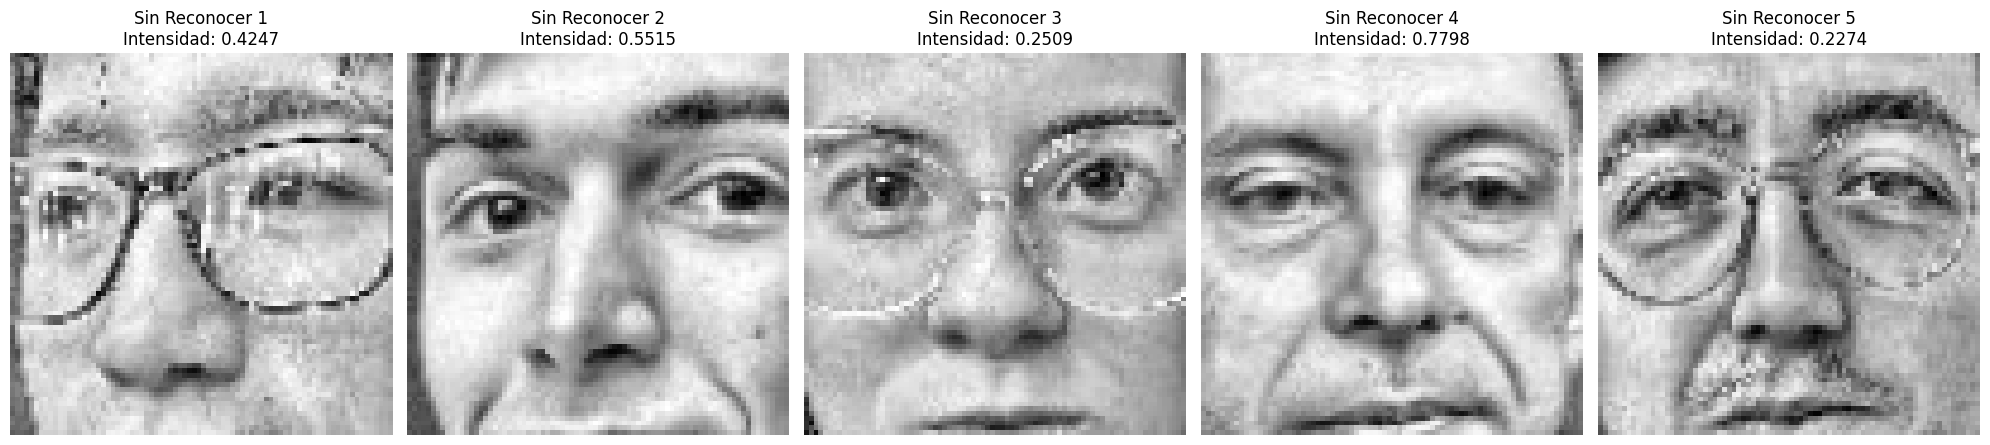

In [ ]:
# Filtrar las predicciones basándose en el umbral de confianza y asignar
umbral_confianza = 0.93 # Umbral de confianza


df_sin_reconocer = df_resultados.filter(pl.col("intensidad_predicha") < umbral_confianza)

# Mostrar las filas que corresponden a sin reconocer
print(f"\nRegistros sin identificar (intensidad < {umbral_confianza}):")
if df_sin_reconocer.height > 0:
    print(df_sin_reconocer)
else:
    print("Se identificaron todos los registros dentro del umbral especificado.")

# Mostrar o procesar las imágenes no identificadas

if not df_sin_reconocer.is_empty():
    print("\nVisualizando las primeras 5 imágenes sin reconocer:")
    sin_reconocer_paths = df_sin_reconocer.select("ruta_imagen").to_numpy().flatten()

    # We no longer need the original indices from the 'imagenes' list.
    # We can directly iterate over the paths in sin_reconocer_paths.

    # Visualizar las primeras 5 imágenes directly from sin_reconocer_paths
    num_to_show = min(5, len(sin_reconocer_paths))
    fig, axes = plt.subplots(1, num_to_show, figsize=(20, 5))

    if num_to_show == 1:
        axes = [axes] # Ensure axes is an array even for a single image
    elif num_to_show == 0: # Handle the case where there are no images to show
        print("No images to show below the threshold.")
        plt.close(fig) # Close the figure if no images are displayed
        pass # Skip the rest of the loop if no images
    else:
        # Flatten the axes array for easy iteration if there's more than one subplot
        axes = axes.flatten()


    for i in range(num_to_show):
        img_path = sin_reconocer_paths[i] # Use the path directly from the filtered list
        # To get the intensity for this specific image, we need to look it up in df_sin_reconocer
        current_sin_reconocer_row = df_sin_reconocer.filter(pl.col("ruta_imagen") == img_path)
        if current_sin_reconocer_row.height > 0:
            current_intensity = current_sin_reconocer_row["intensidad_predicha"][0]
        else:
            current_intensity = float('nan') # Should not happen if path is from the dataframe

        try:
            img = mpimg.imread(img_path)
            axes[i].imshow(img, cmap='gray') # assuming they are grayscale images
            axes[i].set_title(f"Sin Reconocer {i+1}\nIntensidad: {current_intensity:.4f}")
            axes[i].axis('off')
        except FileNotFoundError:
            axes[i].set_title(f"Error loading\n{os.path.basename(img_path)}")
            axes[i].axis('off')
            print(f"Error loading image for visualization {img_path}: File not found")
        except Exception as e:
            axes[i].set_title(f"Error loading\n{os.path.basename(img_path)}")
            axes[i].axis('off')
            print(f"Error loading image for visualization {img_path}: {e}")

    if num_to_show > 0: # Only show the plot if there were images to display
        plt.tight_layout()
        plt.show()
else:
    print("Sin imagenes sin reconocer dentro del umbral para mostrar.")


# Visualizacion de la imagenes con la prediccion


Cantidad de imágenes sin reconocer (Intensidad < 0.01): 0

Mostrando imágenes reconocidas (Intensidad >= 0.01):


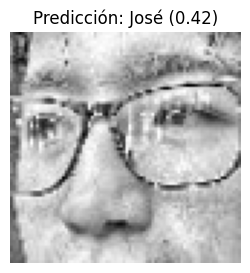

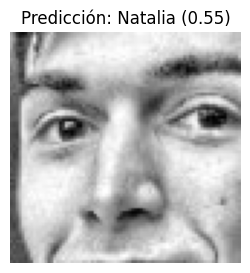

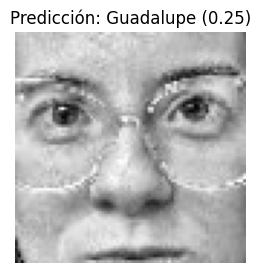

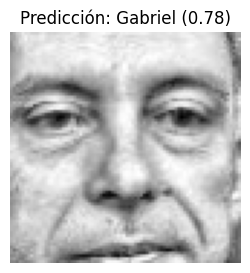

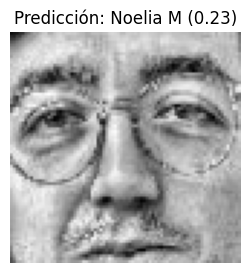

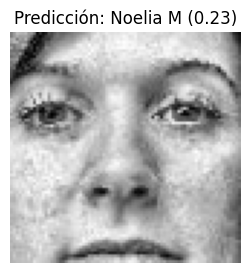

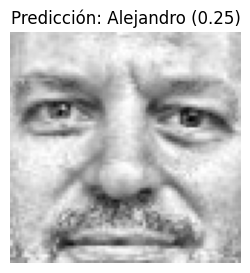

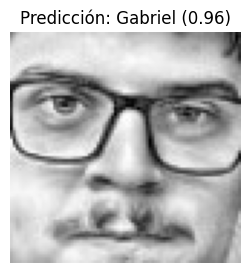

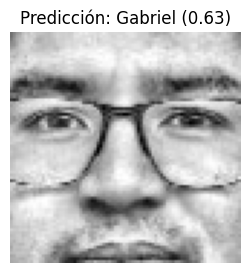

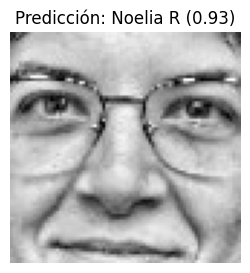

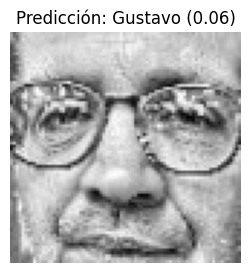

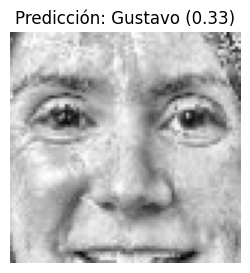

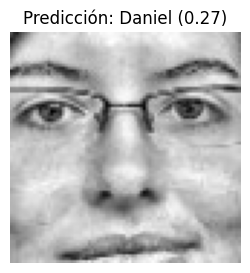

Visualización de imágenes reconocidas completada.
No hay imágenes sin reconocer por debajo del umbral especificado para mostrar.


In [ ]:
# Filtra los resultados en base al umbral de confianza para reconomiento
df_reconocidas = df_resultados.filter(pl.col("intensidad_predicha") >= umbral_confianza)

# Cuenta la cantidad de imagenes sin reconocer
num_sin_reconocer = df_sin_reconocer.height

print(f"\nCantidad de imágenes sin reconocer (Intensidad < {umbral_confianza}): {num_sin_reconocer}")

# Visualización de las imágenes reconocidas por encima del umbral
if not df_reconocidas.is_empty():
    print(f"\nMostrando imágenes reconocidas (Intensidad >= {umbral_confianza}):")
    for row in df_reconocidas.iter_rows(named=True):
        ruta_imagen = row["ruta_imagen"]
        prediccion = row["etiqueta_predicha"]
        intensidad = row["intensidad_predicha"]
        try:
            img = mpimg.imread(ruta_imagen)
            plt.figure(figsize=(3, 3))
            plt.imshow(img, cmap='gray') # Usar cmap='gray' si son imágenes en escala de grises
            plt.title(f"Predicción: {prediccion} ({intensidad:.2f})")
            plt.axis('off') # Ocultar ejes
            plt.show()
        except FileNotFoundError:
            print(f"Error: No se encontró la imagen en {ruta_imagen}")
        except Exception as e:
            print(f"Error al mostrar la imagen {ruta_imagen}: {e}")
    print("Visualización de imágenes reconocidas completada.")
else:
    print("No hay imágenes reconocidas por encima del umbral especificado para mostrar.")

# Visualización de las imágenes sin reconocer (las que están en df_sin_reconocer)
if not df_sin_reconocer.is_empty():
    print(f"\nMostrando imágenes sin reconocer (Intensidad < {umbral_confianza}):")
    for row in df_sin_reconocer.iter_rows(named=True):
        ruta_imagen = row["ruta_imagen"]
        intensidad = row["intensidad_predicha"]
        try:
            img = mpimg.imread(ruta_imagen)
            plt.figure(figsize=(3, 3))
            plt.imshow(img, cmap='gray') # Usar cmap='gray' si son imágenes en escala de grises
            plt.title(f"Sin Reconocer ({intensidad:.2f})")
            plt.axis('off') # Ocultar ejes
            plt.show()
        except FileNotFoundError:
            print(f"Error: No se encontró la imagen en {ruta_imagen}")
        except Exception as e:
            print(f"Error al mostrar la imagen {ruta_imagen}: {e}")
    print("Visualización de imágenes sin reconocer completada.")
else:
    print("No hay imágenes sin reconocer por debajo del umbral especificado para mostrar.")
